In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import networkx as nx


From source:

The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database.

In [3]:
complaints_df = pd.DataFrame()
cols = ['Date received', 
        'Product', 
        'Sub-product', 
        'Issue', 
        'Sub-issue',
        'Consumer complaint narrative', 
        'Company public response', 
        'Company', 
        'State', 
        'Date sent to company', 
        'Company response to consumer', 
        'Timely response?', 
        'Consumer disputed?']
for c in pd.read_csv('data/Consumer_Complaints.csv', chunksize = 10000, header=0, usecols=cols):
    complaints_df = complaints_df.append(c)

In [4]:
complaints_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?
0,09/20/2019,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"CCS Financial Services, Inc.",IL,09/20/2019,Closed with explanation,Yes,NaN
1,09/20/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with fraud alerts or security freezes,NaN,NaN,NaN,"ONEMAIN FINANCIAL HOLDINGS, LLC.",WA,09/20/2019,In progress,Yes,NaN
2,09/20/2019,Checking or savings account,Checking account,Managing an account,Problem accessing account,NaN,NaN,ALLY FINANCIAL INC.,CA,09/20/2019,In progress,Yes,NaN
3,09/20/2019,Debt collection,Medical debt,Attempts to collect debt not owed,Debt was result of identity theft,NaN,NaN,"Commonwealth Financial Systems, Inc.",NV,09/20/2019,Closed with explanation,Yes,NaN
4,09/20/2019,"Payday loan, title loan, or personal loan",Payday loan,Can't stop withdrawals from your bank account,NaN,NaN,NaN,"Tennessee Quick Cash, Inc.",TN,09/20/2019,In progress,Yes,NaN


In [5]:
print(str(complaints_df.iloc[-1, 0]) + ' - ' + str(complaints_df.iloc[0, 0]))

12/01/2011 - 09/20/2019


### Get complaints from years January 1, 2012 through June 30, 2019

In [6]:
complaints_df['Date received'] = pd.to_datetime(complaints_df['Date received'], format='%m/%d/%Y')
complaints_df['Date sent to company'] = pd.to_datetime(complaints_df['Date sent to company'], format='%m/%d/%Y')
complaints_df_cut = complaints_df[(complaints_df['Date received'] >= pd.to_datetime('01/01/2012', format='%m/%d/%Y')) &
           (complaints_df['Date received'] <= pd.to_datetime('06/30/2019', format='%m/%d/%Y'))]
print(str(complaints_df_cut.iloc[-1, 0]) + ' - ' + str(complaints_df_cut.iloc[0, 0]))

2012-01-01 00:00:00 - 2019-06-30 00:00:00


In [7]:
df_equifax = complaints_df_cut[complaints_df_cut['Company'] == 'EQUIFAX, INC.']
equifax_complaints = df_equifax['Date received'].value_counts()
equifax_complaints = df_equifax.groupby(by=[df_equifax['Date received'].dt.year, 
                                            df_equifax['Date received'].dt.month])['Date received'].value_counts()
equifax_complaints = equifax_complaints.groupby([equifax_complaints.index.get_level_values(0),
                                                equifax_complaints.index.get_level_values(1)]).sum()

In [8]:
print(str(df_equifax.iloc[-1, 0]) + ' - ' + str(df_equifax.iloc[0, 0]))

2012-10-14 00:00:00 - 2019-06-30 00:00:00


In [9]:
equifax_complaints

Date received  Date received
2012           10                127
               11                265
               12                230
2013           1                 271
               2                 372
                                ... 
2019           2                2571
               3                3206
               4                3145
               5                3339
               6                3518
Name: Date received, Length: 81, dtype: int64

In [10]:
equifax_complaints_index = pd.to_datetime({'year': equifax_complaints.index.get_level_values(0),
                                           'month': equifax_complaints.index.get_level_values(1),
                                           'day': 1})

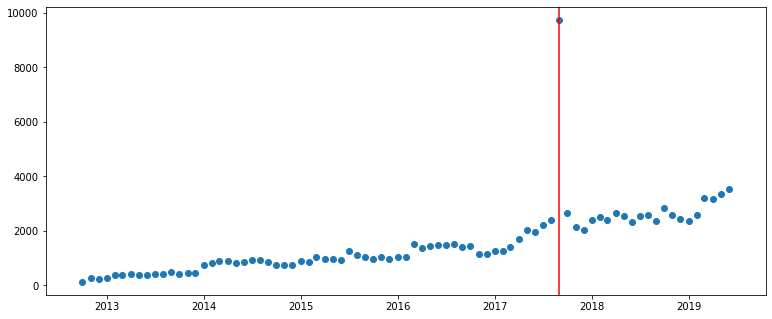

In [11]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_axes([0,0,1,1])
ax.scatter(y = equifax_complaints, x = equifax_complaints_index)
ax.axvline(x=pd.to_datetime('09/01/2017', format='%m/%d/%Y'), color='r')

plt.show()

## Which Financial Institutions have the most complaints per consumer account

In [12]:
import os
accnts_df = pd.DataFrame()
directory = 'data/transaction_accounts'
for file in os.listdir(directory):
    quarter = pd.to_datetime(file.split('_')[2], format='%Y%m%d')
    temp_df = pd.read_csv(os.path.join(directory,file), header=0, usecols=['namehcr', 'trnipcoc'])
    temp_df = temp_df.dropna()
    temp_df['date'] = quarter
    accnts_df = accnts_df.append(temp_df)
accnts_df.columns = ['company', 'num_indiv_accnts', 'date']
accnts_df = pd.DataFrame(accnts_df.groupby(by=['date', 'company']).sum())
accnts_df = accnts_df.reset_index()
accnts_df['company'] = accnts_df['company'].str.strip()

In [13]:
complaints_count = complaints_df_cut[['Date received', 'Company']]
complaints_count = complaints_count.dropna()
complaints_count.columns = ['date', 'company']
# Convert to counts for quarterly
complaints_count = complaints_count.groupby(by=[complaints_count['date'].dt.to_period('Q'), 'company'])['date'].value_counts()
complaints_count = complaints_count.groupby([complaints_count.index.get_level_values(0), complaints_count.index.get_level_values(1)]).sum()
complaints_count = pd.DataFrame(complaints_count)
complaints_count.columns = ['complaints']
complaints_count = complaints_count.reset_index()
complaints_count['company'] = complaints_count['company'].str.strip()


In [14]:
attributes_df = pd.read_csv('data/CSV_ATTRIBUTES_ACTIVE.CSV', header=0, usecols=['#ID_RSSD', 'NM_LGL', 'NM_SHORT'])
attributes_df.columns = ['id', 'company', 'company_short']
attributes_df['company'] = attributes_df['company'].str.strip()
relationships_df = pd.read_csv('data/CSV_RELATIONSHIPS.CSV', header=0, usecols=['#ID_RSSD_PARENT', 'ID_RSSD_OFFSPRING', 'D_DT_END'])
relationships_df.columns = ['id_parent', 'id', 'end_date']
relationships_df['end_year'] = relationships_df['end_date'].str.split().apply(lambda x: x[0]).str.split('/').apply(lambda x: int(x[-1]))
relationships_df.loc[relationships_df['end_year'] == 9999, 'end_date'] = None # Make current relationship end_dates None for datetime conversion
relationships_df['end_date'] = pd.to_datetime(relationships_df['end_date'])

#### Get the ids for the companies and add their parent id if they have one

In [15]:
accnts_df = accnts_df.merge(attributes_df, on='company', how='left')
accnts_df = accnts_df.merge(relationships_df, on='id', how='left')

                      
complaints_count = complaints_count.merge(attributes_df, on='company', how='left')
complaints_count = complaints_count.merge(relationships_df, on='id', how='left')

# Get ids for companies who has no parent, presently has a parent, or had a parent through the data collection date
complaints_count = complaints_count[(complaints_count['end_date'].isnull()) | (complaints_count['date'].dt.start_time < complaints_count['end_date'])]
accnts_df = accnts_df[(accnts_df['end_date'].isnull()) | (accnts_df['date'] < accnts_df['end_date'])]
accnts_df['date'] = accnts_df['date'].dt.to_period('Q') # Convert date to quarterly to reconcile with complaints

In [16]:
parent_child_df = accnts_df.merge(complaints_count, how='outer', on=['date', 'company', 'id', 'company_short', 'id_parent', 'end_date', 'end_year'])
parent_child_df = parent_child_df.drop(['end_date', 'end_year'], axis=1)

In [17]:
temp_replace = pd.DataFrame(parent_child_df.groupby(by=['date', 'id'])['complaints', 'num_indiv_accnts'].sum()) # Add these to other rows in this df
parent_child_df = parent_child_df.sort_values('id_parent').groupby(['date', 'id']).first() # Sort on id_parent to make sure that it is 'first', rest of data will be replaced
parent_child_df = parent_child_df.drop(['complaints', 'num_indiv_accnts'], axis=1).merge(temp_replace, on=['date','id'], how='inner')

In [18]:
child_df = parent_child_df[~parent_child_df['id_parent'].isnull()]

#### Now we are left with a parent child dataframe with only parents

In [19]:
relationships_graph = nx.from_pandas_edgelist(df=relationships_df, source='id_parent', target='id',edge_attr=['end_date'], create_using=nx.DiGraph())

In [20]:
def get_root_nodes(node, g, passed_path = []):
    parents = list(g.predecessors(node))
    if passed_path:
        path = passed_path
    else:
        path = []
    newest_parent = None
    newest_date = pd.Timestamp(0)
    for p in parents: # Get the most current relationship
        edge_data = g.get_edge_data(p, node)
        if edge_data and pd.isna(edge_data['end_date']): # If null relationship is still active
            newest_parent = p
            newest_date = None
            break
        elif edge_data and edge_data['end_date'] > newest_date:
            newest_parent = p
            newest_date = edge_data['end_date']
    if list(filter(lambda x: newest_parent == x[0], path)): # Loop in graph
        newest_node = None
        newest_date = pd.Timestamp(0)
        for n in path:
            if pd.isna(n[1]): # Relationship is current, return this
                return n[0]
            elif n[1] > newest_date:
                newest_node = n[0]
                newest_date = n[1]
        return newest_node # Get the most recent
    else:
        path.append((newest_parent, newest_date))
    if len(parents)==0:
        return node
    else:
        return get_root_nodes(newest_parent, g, passed_path=path)

In [21]:
child_df = parent_child_df[~parent_child_df['id_parent'].isnull()]
add_to_parent = pd.DataFrame(child_df.groupby(by=['date', 'id_parent'])['complaints', 'num_indiv_accnts'].sum()) # Add these to other rows in this df
add_to_parent = add_to_parent.reset_index()
add_to_parent['id_parent'] = add_to_parent['id_parent'].apply(get_root_nodes, args=(relationships_graph,[]))
add_to_parent = add_to_parent.set_index(['date', 'id_parent'])
add_to_parent.index.names = ['date', 'id']
diff_idx = parent_child_df.index.difference(child_df.index)
parent_child_df = parent_child_df.loc[diff_idx] # drop children from df, leaving just parents

parent_child_df['complaints'] = parent_child_df['complaints'].add(add_to_parent['complaints'], fill_value=0).groupby(by=['date', 'id']).sum() # Add these to other rows in this df
parent_child_df['num_indiv_accnts'] = parent_child_df['num_indiv_accnts'].add(add_to_parent['num_indiv_accnts'], fill_value=0).groupby(by=['date', 'id']).sum()
parent_child_df = parent_child_df.drop('id_parent', axis=1)
parent_child_df = parent_child_df[(parent_child_df != 0).all(1)]

In [169]:

colors = {} # Denotes number of accounts at company

def complaints_bar(year):
    plot_df = parent_child_df.loc[(year,)].sort_values('complaints_per_10k', ascending=False).head(10)
    ax.clear()
    company_list = []
    for name in plot_df['company_short'].str.split():
        if len(name)<3:
            company_list.append(' '.join(name).title())
        else:
            company_list.append(' '.join(name[:2]).title())

    plt.bar(company_list, height=plot_df['complaints_per_10k'])
    plt.ylim(0,100)
    plt.xticks(rotation=30, ha='right')

In [174]:
top15_accnts = accnts_df.sort_values('num_indiv_accnts', ascending=False)['id'].unique()[:15]

colors = {} # Denotes number of accounts at company

def complaints_bar(year):
    plot_df = parent_child_df.loc[(slice(None), top15_accnts),:]
    plot_df = plot_df.loc[(year,)]
    ax.clear()
    company_list = []
    for name in plot_df['company_short'].str.split():
        if len(name)<3:
            company_list.append(' '.join(name).title())
        else:
            company_list.append(' '.join(name[:2]).title())

    plt.bar(company_list, height=plot_df['complaints_per_10k'])
    plt.ylim(0,5)
    plt.xticks(rotation=30, ha='right')

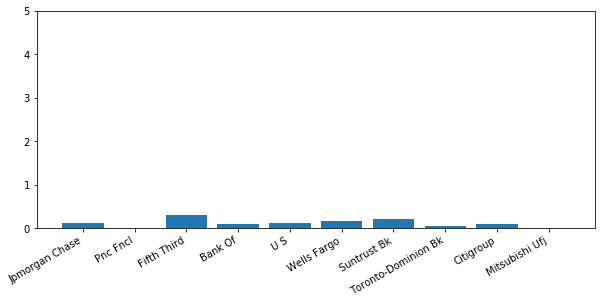

In [179]:
fig, ax = plt.subplots(figsize=(10,4))
from IPython.display import HTML
complaints_anim = animation.FuncAnimation(fig, complaints_bar, frames=parent_child_df.index.droplevel(1).unique())
HTML(complaints_anim.to_jshtml())